# Homeworks
1. Find the answer to the question raised in the lab1

    Some helpful resources:
- DeepWalk: https://arxiv.org/pdf/1403.6652.pdf
- Word2vec: https://arxiv.org/pdf/1301.3781.pdf
- Repository Github of Word2vec at [this link](https://github.com/RaRe-Technologies/gensim)
2. Implement a simple word2vec algorithm for the DeepWalk (Attributes for each node should be created).
3. Use some libraries to solve a real problem

# Answer

## Implement Word2vec

### Download data and install packages

In [ ]:
!pip install karateclub==1.2.0
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.6 MB/s eta 0:00:00
  Created wheel for karateclub: filename=karateclub-1.2.0-py3-none-any.whl size=94311 sha256=547eb5880a9196dfd867bb3fd92eee32a1938b423892b4272f57be5e7c40b30b
  Stored in directory: /root/.cache/pip/wheels/41/83/22/2ea49cf105f1a344e9f5813bc307112147af91b8480be84361
Successfully built karateclub
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.6 MB/s eta 0:00:00


In [ ]:
!pip uninstall numpy -y
!pip install numpy

In [ ]:
!gdown --id "1RmrHId0d-uY7kJCSgCtNYbwYfp4Oum3c&export=download"
!unrar x -Y "/content/lab3.rar" -d "/content/"

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1RmrHId0d-uY7kJCSgCtNYbwYfp4Oum3c&export=download
To: /content/lab3.rar
100% 1.54M/1.54M [00:00<00:00, 168MB/s]

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/lab3.rar

Extracting  /content/lab3_attributes.csv                                   0%  OK 
Extracting  /content/facebook_features.json                               28%  OK 
Extracting  /content/facebook_target.csv                                  59%  OK 
Extracting  /content/lab3_edgelist.txt                                    59%  OK 
Extracting  /content/facebook_edges.csv                                  100%  OK 
All OK


### Packages

In [ ]:
# Task 1
import networkx as nx
from joblib import Parallel, delayed
import random
import itertools
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from gensim.models import Word2Vec
# Task 2
import json
import umap
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
from karateclub.utils.walker import RandomWalker
from gensim.models.word2vec import Word2Vec
import seaborn as sns

### Utils

In [ ]:
def partition_num(num, workers):
    if num % workers == 0:
        return [num//workers]*workers
    else:
        return [num//workers]*workers + [num % workers]

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def get_attributes_of_node(node_paths):
  node_paths_attributes = []
  # Get attribute (word) for each node
  df_attr = pd.read_csv("lab3_attributes.csv").astype(str)
  dict_attr = {}
  for i in range(len(df_attr)):
    dict_attr[df_attr.iloc[i, 0]] = df_attr.iloc[i, 1]
  for path in node_paths:
    for index, node in enumerate(path):
      path[index] = dict_attr[node]
    node_paths_attributes.append(path)
  return node_paths_attributes

def preprocessing(sentences):
    training_data = []
    for sentence in sentences:
        x = [word for word in sentence]
        training_data.append(x)
    return training_data


def prepare_data_for_training(sentences,w2v):
    data = {}
    for sentence in sentences:
        for word in sentence:
            if word not in data:
                data[word] = 1
            else:
                data[word] += 1
    vocab_size = len(data)
    data = sorted(list(data.keys()))
    vocab = {}
    for i in range(len(data)):
        vocab[data[i]] = i

    for sentence in sentences:
        for i in range(len(sentence)):
            center_word = [0 for x in range(vocab_size)]
            center_word[vocab[sentence[i]]] = 1
            context = [0 for x in range(vocab_size)]

            for j in range(i-w2v.window_size,i+w2v.window_size):
                if i!=j and j>=0 and j<len(sentence):
                    context[vocab[sentence[j]]] += 1
            w2v.X_train.append(center_word)
            w2v.y_train.append(context)
    w2v.initialize(vocab_size, data)

    return w2v.X_train,w2v.y_train


### TO DO

In [ ]:
class word2vec():
    def __init__(self, embedding_dim=100, window_size=5):
        self.embedding_dim = embedding_dim
        self.window_size = window_size
        self.word_to_index = {}
        self.index_to_word = {}
        self.embeddings = None
        self.X_train = []
        self.y_train = []

    def initialize(self, vocab_size, vocab):
        self.embeddings = np.random.uniform(-0.5 / self.embedding_dim, 0.5 / self.embedding_dim,
                                            (vocab_size, self.embedding_dim))
        self.word_to_index = {word: i for i, word in enumerate(vocab)}
        self.index_to_word = {i: word for i, word in enumerate(vocab)}

    def one_hot(self, index, vocab_size):
        one_hot_vector = np.zeros(vocab_size)
        one_hot_vector[index] = 1
        return one_hot_vector

    def update_weights(self, center_word, context, learning_rate):
        center_embedding = self.embeddings[np.where(center_word == 1)[0][0]]
        scores = np.dot(self.embeddings, center_embedding)
        probabilities = self.softmax(scores)

        # Compute loss (cross-entropy)
        loss = -np.sum(context * np.log(probabilities + 1e-10))
        gradient = probabilities - context
        self.embeddings -= learning_rate * np.outer(gradient, center_embedding)

        return loss

    def train(self, epochs=100, learning_rate=0.01):
        for epoch in range(epochs):
            total_loss = 0
            for center_word, context in zip(self.X_train, self.y_train):
                loss = self.update_weights(center_word, context, learning_rate)
                total_loss += loss

            print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}')

    def predict(self, word, top_n=3):
        if word not in self.word_to_index:
            raise ValueError(f"Word '{word}' not in vocabulary.")
            # print((f"Word '{word}' not in vocabulary."))
        word_vector = self.embeddings[self.word_to_index[word]]
        similarities = []

        for i in range(len(self.index_to_word)):
            if self.index_to_word[i] != word:
                other_vector = self.embeddings[i]
                similarity = np.dot(word_vector, other_vector) / (np.linalg.norm(word_vector) * np.linalg.norm(other_vector))
                similarities.append((self.index_to_word[i], similarity))

        similarities.sort(key=lambda x: -x[1])
        return similarities[:top_n]




### DeepWalk

In [ ]:
class RandomWalker:
  def __init__(self, G, num_walks, walk_length):
      """
      :param G: Graph
      :param num_walks: a number of walks
      :param walk_length: Length of a walk. Each walk is considered as a sentence
      """
      self.G = G
      self.num_walks = num_walks
      self.walk_length = walk_length


  def deepwalk_walk(self, start_node):
      """
      :param start_node: Starting node of a walk
      """
      walk = [start_node]
      while len(walk) < self.walk_length:
          cur = walk[-1]
          # Check if having any neighbors at the current node
          cur_nbrs = list(self.G.neighbors(cur))
          if len(cur_nbrs) > 0:
              # Random walk with the probability of 1/d(v^t). d(v^t) is the node degree
              walk.append(random.choice(cur_nbrs))
          else:
              break
      return walk


  def simulate_walks(self, workers=1, verbose=0):
      """
      :param workers: a number of workers running in parallel processing
      :param verbose: progress bar
      """
      G = self.G
      nodes = list(G.nodes())
      results = Parallel(n_jobs=workers, verbose=verbose)(
          delayed(self._simulate_walks)(nodes) for num in
          partition_num(self.num_walks, workers))
      walks = list(itertools.chain(*results))
      return walks


  # INFORMATION EXTRACTOR
  def _simulate_walks(self, nodes):
      walks = []
      # Iterate all walks per vertex
      for _ in range(self.num_walks):
          random.shuffle(nodes)
          # Iterate all nodes in a walk
          for v in nodes:
            walks.append(self.deepwalk_walk(start_node=v))
      return walks

In [ ]:
class DeepWalk:
    def __init__(self, graph, walk_length, num_walks, workers=1):

        self.graph = graph
        self.w2v_model = None
        self._embeddings = {}

        self.walker = RandomWalker(graph, num_walks=num_walks, walk_length=walk_length)
        self.walks = self.walker.simulate_walks(workers=workers, verbose=1)
        self.sentences = get_attributes_of_node(self.walks)


    def train(self, window_size=5, epochs=100):
        print("Learning embedding vectors...")
        training_data = preprocessing(self.sentences)
        w2v = word2vec(window_size, epochs)
        prepare_data_for_training(training_data, w2v)
        w2v.train()
        print("Learning embedding vectors done!")
        self.w2v_model = w2v


    def test(self, word):
        print(self.w2v_model.predict(word,3))

### Run graph embedding

In [ ]:
G = nx.read_edgelist('lab3_edgelist.txt',create_using=nx.DiGraph(),nodetype=None,data=[('weight',int)])# Read graph
model = DeepWalk(G, walk_length=3, num_walks=10, workers=1)#init model
model.train(window_size=5)# train model

Learning embedding vectors...
Epoch 1/100, Loss: 0.0000
Epoch 2/100, Loss: 0.0000
Epoch 3/100, Loss: 0.0000
Epoch 4/100, Loss: 0.0000
Epoch 5/100, Loss: 0.0000
Epoch 6/100, Loss: 0.0000
Epoch 7/100, Loss: 0.0000
Epoch 8/100, Loss: 0.0000
Epoch 9/100, Loss: 0.0000
Epoch 10/100, Loss: 0.0000
Epoch 11/100, Loss: 0.0000
Epoch 12/100, Loss: 0.0000
Epoch 13/100, Loss: 0.0000
Epoch 14/100, Loss: 0.0000
Epoch 15/100, Loss: 0.0000
Epoch 16/100, Loss: 0.0000
Epoch 17/100, Loss: 0.0000
Epoch 18/100, Loss: 0.0000
Epoch 19/100, Loss: 0.0000
Epoch 20/100, Loss: 0.0000
Epoch 21/100, Loss: 0.0000
Epoch 22/100, Loss: 0.0000
Epoch 23/100, Loss: 0.0000
Epoch 24/100, Loss: 0.0000
Epoch 25/100, Loss: 0.0000
Epoch 26/100, Loss: 0.0000
Epoch 27/100, Loss: 0.0000
Epoch 28/100, Loss: 0.0000
Epoch 29/100, Loss: 0.0000
Epoch 30/100, Loss: 0.0000
Epoch 31/100, Loss: 0.0000
Epoch 32/100, Loss: 0.0000
Epoch 33/100, Loss: 0.0000
Epoch 34/100, Loss: 0.0000
Epoch 35/100, Loss: 0.0000
Epoch 36/100, Loss: 0.0000
Epoch 3

In [ ]:
print(model.sentences)
model.test("to")
model.test("this")

## TO DO: Solve a real problem using some libraries

Goal: When we have a large graph dataset like the Facebook dataset below, we want to classify which company (node) will likely belong to a type of page. If we categorize well, we could apply marketing strategies in a domain on a company that we are surveying.
Therefore, our task is to learn a model which can classify a company using related features.


1. Analyze and visualize the dataset Facebook downloaded in [this website](https://snap.stanford.edu/data/facebook-large-page-page-network.html).
2. Use DeepWalk to embed the graph
3. Train a classifier to do the node classification task using the embedding graph from step 2.

You can do many things with the data. I recommend that you could try many tasks with this data, not only the classification task.

### Read data

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
edges_path = '/content/drive/MyDrive/labhw_1/Hw17/musae_facebook_edges.csv'
features_path = '/content/drive/MyDrive/labhw_1/Hw17/musae_facebook_features.json'
targets_path = '/content/drive/MyDrive/labhw_1/Hw17/musae_facebook_target.csv'

### Visualize datasets

Create a graph. If you want to use smaller graph, please try to create one. It will be lighter when running the code.

In [26]:
data_edges = pd.read_csv(edges_path)
data_edges.head()

,id_1,id_2
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829


In [27]:
data_targets = pd.read_csv(targets_path)
data_targets.head()

,id,facebook_id,page_name,page_type
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,1,191483281412,U.S. Consulate General Mumbai,government
2,2,144761358898518,ESET,company
3,3,568700043198473,Consulate General of Switzerland in Montreal,government
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician


In [28]:
with open(features_path) as json_data:
    features = json.load(json_data)
max_feature = np.max([v for v_list in features.values() for v in v_list])
features_matrix = np.zeros(shape=(len(list(features.keys())), max_feature + 1))

i = 0
for k, vs in tqdm(features.items()):
    for v in vs:
        features_matrix[i, v] = 1
    i += 1

100%|██████████| 22470/22470 [00:00<00:00, 40443.57it/s]


### Embedding graph using DeepWalk

Embedding graph using DeepWalk

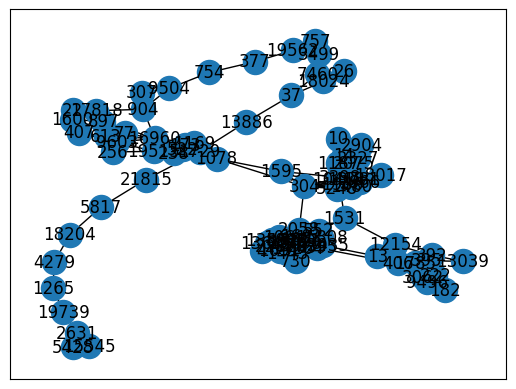

In [ ]:
#Visualize subgraph
graph = nx.convert_matrix.from_pandas_edgelist(data_edges, "id_1", "id_2")
subgraph_nodes = list(nx.dfs_preorder_nodes(graph, 10))[:88]
G = graph.subgraph(subgraph_nodes)
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=pos)

In [30]:
#Random Walk
walker = RandomWalker(walk_length = 20, walk_number = 10)
walker.do_walks(graph)
model = Word2Vec(walker.walks,
                 hs=1,
                 sg=1,
                 negative=0,
                 window=5,
                 min_count=1,
                 workers=4,
                 seed=42)

In [32]:
similar_to = "451"
data_targets.loc[[int(similar_to)+int(v[0]) for v in model.wv.most_similar(similar_to)],:].head()

,id,facebook_id,page_name,page_type
1880,1880,822583537767879,Tempe Police Department,government
14962,14962,444318895614966,برنامج زمام المبادرة - قناة الجزيرة الفضائية,tvshow
15238,15238,300844356716509,Grisbì,company
903,903,261925857331811,Telmário Mota,politician
21921,21921,172834814572,Peter Altmaier,politician


### Train a classifier

Train a classifer from the embedding graph to the target. Here we use the Random Forest classifier.

In [34]:
y = data_targets.loc[[int(i) for i in list(features.keys())], "page_type"]
X = []
for i in y.index:
    X.append(model.wv.__getitem__(str(i)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f1_score(y_test, y_pred, average="micro"))

0.9212283044058746


# THANK YOU
Please dive more into the codes and papers if you are interested.

Thank you for joining all the labs.